c:\Users\mahd\Documents\SimulationRocketPy\RocketPy-master\rocketpy\motors\motor.py:918: UserWarning: burn_time argument (0, 2.505) is out of thrust source time range. Using thrust_source boundary times instead: (0.055, 2.505) s.
If you want to change the burn out time of the curve please use the 'reshape_thrust_curve' argument.
  warnings.warn(


9181.37105

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 0.06 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.707 | e1: -0.012 | e2: 0.012 | e3: -0.707
Euler Angles - Spin φ : 0.00° | Nutation θ: -2.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: -0.06 m/s
Lateral Surface Wind Speed: 3.02 m/s


Launch Rail

Launch Rail Length: 5.918  m
Launch Rail Inclination: 88.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.272 s
Rail Departure Velocity: 48.104 m/s
Rail Departure Stability Margin: 2.477 c
Rail Departure Angle of Attack: 3.598°
Rail Departure Thrust-Weight Ratio: 23.918
Rail Departure Reynolds Number: 4.750e+05


Burn out State

Burn out time: 2.505 s
Altitude at burn out: 560.049 m (AGL)
Rocket velocity at burn out: 342.773 m/s
Freestream velocity at burn out: 342.894 m/s
Mach Number at burn out: 0.997
Kinetic ener

'Completed 9 iterations successfully. Total CPU time: 0.0 s. Total wall time: 20.345585823059082 s'

Number of simulations:  9



BELOW IS FROM SPACEPORT LAUNCH SITE



Apogee Altitude -         Mean Value: 2768.765 m
Apogee Altitude - Standard Deviation: 160.092 m
2456.0528424515783
3003.5523053589045
2
273.7497314536631


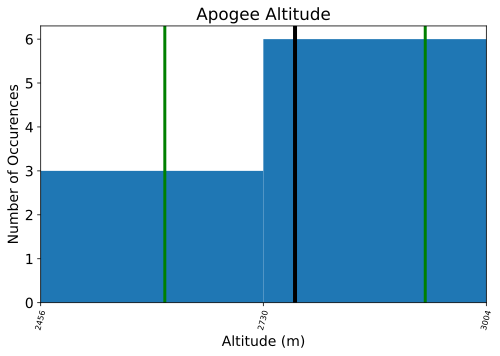

PROBABILITY THE APOGEE IS IN BETWEEN 9900 FEET AND 10100 FEET IS: 3.36%
Average stability of the rocket, out of rail: 1.9601


In [1]:
import sys
from time import process_time, time
from rocketpy import Environment, SolidMotor, Rocket, Flight
import concurrent.futures
from ConcurrentFunctions import flight_settings, export_flight_data, export_flight_error, runFlightWithMonteCarlo
from IPython.display import display
from scipy.stats import norm

import imageio.v2 as imageio
from matplotlib.patches import Ellipse

import ssl
import certifi

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

from rocketpy.plots import flight_plots

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

import numpy as np
from numpy.random import normal, choice

import logging

import openpyxl

# Define variable to load the dataframe
dataframe = openpyxl.load_workbook("WeatherData.xlsx")

# Define variable to read sheet
dataframe1 = dataframe.active

# Iterate the loop to read the cell values

env = Environment(latitude=0, longitude=0, elevation = 0)

import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time
env.set_atmospheric_model(type="Forecast", file = "GFS")
# env.info()

dryMass = 3.197
grainInner =(39.37*10**-3)/2
grainOuter =(82.27*10**-3)/2
density = dryMass / ((np.pi*grainOuter**2)-(np.pi*grainInner**2))
grainHeight = 0.1524
numGrain = 6
totalHeight = grainHeight*numGrain
centralAxis = (0.08333)*dryMass*(grainOuter)**2
centralDiameter = ((1/4)*dryMass*(grainOuter)**2) + (1/12)*dryMass*(totalHeight)**2

MotorOne = SolidMotor(
    thrust_source= "thrustcurve.csv",
    dry_mass= dryMass,
    dry_inertia= (centralAxis,centralAxis,centralDiameter),
    nozzle_radius= (79.32*10**-3)/2 ,
    grain_number= numGrain,
    grain_density= density,
    grain_outer_radius= grainOuter ,
    grain_initial_inner_radius= grainInner,
    grain_initial_height= grainHeight,
    grain_separation= 0,
    grains_center_of_mass_position= 0,
    center_of_dry_mass_position= 0,
    nozzle_position= grainHeight*3.3,
    burn_time= 2.505,
    throat_radius= (29.21*10**-3)/2,
    coordinate_system_orientation="combustion_chamber_to_nozzle",
)

# M1850W.all_info()

#Pretty Much done except grain density and maybe nozzle position

spMass = 16.6
spRadius = 0.155/2
spLength = .152 + .305 + .559 + .508 + .356 + .152

spCentralAxis = (1/12)*spMass*(spRadius)**2
spCentralDiameter = ((1/4)*spMass*(spRadius)**2) + (1/12)*spMass*(spLength)**2

Sp25 = Rocket(
    mass = spMass,
    radius = spRadius,
    inertia = (spCentralDiameter,spCentralDiameter,spCentralAxis), # Calculated via Open Rocket
    coordinate_system_orientation = "nose_to_tail",
    center_of_mass_without_motor = 1.93 , #OpenRocket
    power_off_drag ="Sp25CDOFF10.31.csv", #RAS Aero
    power_on_drag ="Sp25CDON10.31.csv"
)

nose_cone = Sp25.add_nose(length = 0.813, kind = "von karman", position = 0)

fin_set = Sp25.add_trapezoidal_fins(n=4,root_chord=0.279,tip_chord=0.091, span=0.216,fin_Position=2.62,cant_angle=0,sweep_length=0.173)
boattailPos = 0.813+0.152+0.305+0.559+0.508+0.356+0.152
boattail = Sp25.add_tail(top_radius = spRadius,bottom_radius = 0.127/2,length = 0.203,position = boattailPos)

Sp25.add_motor(MotorOne,spLength + nose_cone.length + grainHeight/2 - (totalHeight)/2)
topRB = 2.77-0.26-0.26
rail_buttons = Sp25.set_rail_buttons(
    upper_button_position= topRB,
    lower_button_position= 2.77,
    angular_position=135
)
drogueRadius = 0.61/2

Drogue = Sp25.add_parachute(
    "Drogue",
    cd_s = 0.97*3.1415*(drogueRadius)**2,
    trigger = "apogee"
)
lightRadius = 3.05/2
Light = Sp25.add_parachute(
    "Light",
    cd_s = 2.2*3.1415*(lightRadius)**2,
    trigger = 450
)

test_flight = Flight(
    rocket=Sp25, environment=env ,rail_length = 5.7-(spLength-topRB),inclination = 88,heading =90
)
print(str(MotorOne.total_impulse))
meanTemp = 60
analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (Sp25.mass, 0.001),
    # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "rocket_inertia_11": (Sp25.I_11_without_motor, 0.036),
    # Rocket's inertia moment relative to its axis (kg*m^2)
    "rocket_inertia_33": (Sp25.I_33_without_motor, 0.00001),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (MotorOne.dry_mass, 0.001),
    # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    "motor_inertia_11": (MotorOne.dry_I_11, 0.016),
    # Motors's dry inertia moment relative to its axis (kg*m^2)
    "motor_inertia_33": (MotorOne.dry_I_33, 0.00001),
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)

    # THIS is likely wrong, go back to check it

    "motor_dry_mass_position": (Sp25.motor_center_of_dry_mass_position, 0.001),
    # Motor total impulse (N*s)
    "impulse": (MotorOne.total_impulse, 25.3),
    # Motor burn out time (s)
    "burn_time": (MotorOne.burn_time[1], .3),
    # Motor's nozzle radius (m)
    "nozzle_radius": (MotorOne.nozzle_radius, 0.5 / 1000),
    # Motor's nozzle throat radius (m)
    "throat_radius": (MotorOne.throat_radius, 0.5 / 1000),
    # Motor's grain separation (axial distance between two grains) (m)
    "grain_separation": (MotorOne.grain_separation, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (MotorOne.grain_density, 20),
    # Motor's grain outer radius (m)
    "grain_outer_radius": (MotorOne.grain_outer_radius, 0.3 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (MotorOne.grain_initial_inner_radius, 0.3 / 1000),
    # Motor's grain height (m)
    "grain_initial_height": (MotorOne.grain_initial_height, 1 / 1000),
    # Rocket's radius (kg*m^2)
    "radius": (Sp25.radius, 0.001),
    # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "nozzle_position": (Sp25.center_of_dry_mass_position-Sp25.nozzle_position, 0.001),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (Sp25.center_of_dry_mass_position-(MotorOne.center_of_dry_mass_position + Sp25.motor_position), 0.0001),

    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_off_drag": (1, 0.05),
    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_on_drag": (1, 0.05),
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "nose_distance_to_CM": (Sp25.center_of_dry_mass_position-nose_cone.length, 0.001),
    # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    "fin_distance_to_CM": (fin_set.fin_Position - Sp25.center_of_dry_mass_position, 0.001),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (test_flight.inclination, 1),
    # Launch rail heading relative to north (degrees)
    "heading": (test_flight.heading, 2),
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (Drogue.cd_s, 0.02),
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (Drogue.lag, 0.2),
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (Drogue.lag, 0.1),
    # temperature in kelvin
    "temperature": ((meanTemp - 32) * 5/9 + 273.15, 15),
    # atmospheric pressure in pascals
    "atmosphere_pressure": (101325, 5000),
    # wind speed correspondign with u-vector in m/s
    "wind_u_speed": (2, 1),
    # wind speed corresponding with v-vector in m/s
    "wind_v_speed": (2, 1)
}
test_flight.info()
envParams = {
    "latitude": 32.9823279,
    "longitude": -106.9490122,
    "elevation": 1400.556,
    "type": "custom_atmosphere",
    "file": None
}
print("\n\n\nfirst flight done, out of rail stability: " + str(test_flight.out_of_rail_stability_margin) + "\n\n\n")


currentRow = 1
# M1850W.all_info()

def setup_logging():
    class MyHandler(logging.FileHandler):
        def emit(self, record):
            super().emit(record)  # Call the superclass's emit method
            self.flush()  # Flush after each log message

    # Use your custom handler
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = MyHandler('app.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

for row in dataframe1.iter_rows(1, dataframe1.max_row):
        setup_logging()
        envParams["file"] = row[0].value
        # env.all_info()
        # Create data files for inputs, outputs and error logging
        filename = "MonteCarlo" + str(currentRow)
        MonteCarloErrorFile = open(str(filename) + ".Errors.txt", "w")
        MonteCarloInputFile = open(str(filename) + ".Input.txt", "w")
        MonteCarloOutputFile = open(str(filename) + ".Output.txt", "w")

        initial_wall_time = time()
        initial_cpu_time = process_time()
        # Iterate over flight settings
        out = display("Starting", display_id=True)
        number_of_simulations = 9
        totalProcesses = 3
        simsPerProcess = number_of_simulations / totalProcesses

        #start multiprocessing
        if __name__ == "__main__":
            with concurrent.futures.ProcessPoolExecutor(max_workers=totalProcesses) as executor:
                results = [executor.submit(runFlightWithMonteCarlo, simsPerProcess, envParams, analysis_parameters, initial_cpu_time) for _ in range(totalProcesses)] 
                for result in concurrent.futures.as_completed(results):
                    MonteCarloInputFile.write(result.result()[0] + "\n")
                    MonteCarloOutputFile.write(result.result()[1] + "\n")
                    MonteCarloErrorFile.write(result.result()[2] + "\n")

        ## Print and save total time
        final_string = f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
        out.update(final_string)
        MonteCarloInputFile.write(final_string + "\n")
        MonteCarloOutputFile.write(final_string + "\n")
        MonteCarloErrorFile.write(final_string + "\n")

        ## Close files
        MonteCarloInputFile.close()
        MonteCarloOutputFile.close()
        MonteCarloErrorFile.close()

        # Initialize variable to store all results
        dispersion_general_results = []

        dispersion_results = {
            "out_of_rail_time": [],
            "out_of_rail_velocity": [],
            "apogee_time": [],
            "apogee_altitude": [],
            "apogee_x": [],
            "apogee_y": [],
            "impact_time": [],
            "impact_x": [],
            "impact_y": [],
            "impact_velocity": [],
            "initial_static_margin": [],
            "out_of_rail_static_margin": [],
            "out_of_rail_stability_margin": [],
            "final_static_margin": [],
            "number_of_events": [],
            "max_velocity": [],
            "drogue_triggerTime": [],
            "drogue_inflated_time": [],
            "drogue_inflated_velocity": [],
            "execution_time": [],
        }

        # Get all dispersion results
        # Get file
        dispersion_output_file = open(str(filename) + ".Output.txt", "r+")

        # Read each line of the file and convert to dict
        for line in dispersion_output_file:
            # Skip comments lines
            if line[0] != "{":
                continue
            # Eval results and store them
            flight_result = eval(line)
            dispersion_general_results.append(flight_result)
            for parameter_key, parameter_value in flight_result.items():
                dispersion_results[parameter_key].append(parameter_value)

        # Close data file
        dispersion_output_file.close()

        # Print number of flights simulated
        N = len(dispersion_general_results)
        print("Number of simulations: ", N)

        if currentRow <= 2:
            img = plt.imread("SpaceportLaunchSite.png")
            print("\n\n\nBELOW IS FROM SPACEPORT LAUNCH SITE\n\n\n")
        else:
            img = plt.imread("SeymourLaunchSite.png")
            print("\n\n\nBELOW IS FROM SEYMOUR LAUNCH SITE\n\n\n")
        # Import background map


        # Retrieve dispersion data por apogee and impact XY position
        apogee_x = np.array(dispersion_results["apogee_x"])
        apogee_y = np.array(dispersion_results["apogee_y"])
        impact_x = np.array(dispersion_results["impact_x"])
        impact_y = np.array(dispersion_results["impact_y"])


        # Define function to calculate eigen values
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:, order]
        
        mean = np.mean(dispersion_results["apogee_altitude"])
        deviation = np.std(dispersion_results["apogee_altitude"])
        print(
            f'Apogee Altitude -         Mean Value: {mean:0.3f} m'
        )
        print(
            f'Apogee Altitude - Standard Deviation: {deviation:0.3f} m'
        )

        minimum = np.min(dispersion_results["apogee_altitude"])
        print(minimum)
        maximum = np.max(dispersion_results["apogee_altitude"])
        print(maximum)
        theBins = list()

        #using scott's rule to find the number of bins
        binWidth = 3.5 * deviation / np.power(len(dispersion_results["apogee_altitude"]), 1/3)
        numBins = int(np.round((maximum-minimum)/binWidth))

        print(numBins)
        changeInZ = (maximum - minimum) / numBins
        print(changeInZ)
        #test add
        zIterator = minimum
        for iterator in range(numBins):
            theBins.append(zIterator)
            zIterator += changeInZ
        theBins.append(np.ceil(zIterator))
        plt.figure()
        plt.xlim(minimum, maximum)
        minTextSize = 8
        maxTickCount = 50
        xTickBins = theBins
        if(numBins > maxTickCount):
            xTickBins = list()
            changeInZ = (maximum - minimum) / 50.0
            zIterator = minimum
            for iterator in range(50):
                xTickBins.append(zIterator)
                zIterator += changeInZ
        binListToString = list()
        for currentBin in xTickBins:
            binListToString.append(str(round(currentBin)))
        plt.xticks(ticks = xTickBins, labels = binListToString, rotation = 75, fontsize = minTextSize)
        plt.hist(dispersion_results["apogee_altitude"], bins=theBins)
        plt.title("Apogee Altitude")
        plt.xlabel("Altitude (m)")
        plt.ylabel("Number of Occurences")

        plt.axvline(mean, color='k', linestyle='solid', linewidth=4)
        plt.axvline(mean - deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.show()
        currentRow+=1
        probabilityLowerBound = 9900 * 0.3048
        probabilityUpperBound = 10100 * 0.3048
        lowerZ = (probabilityLowerBound - mean)/deviation
        upperZ = (probabilityUpperBound - mean)/deviation
        probabilityInRange = norm.cdf(upperZ) - norm.cdf(lowerZ)
        print("PROBABILITY THE APOGEE IS IN BETWEEN " + str(round(probabilityLowerBound * (1/0.3048))) + " FEET AND " + str(round(probabilityUpperBound * (1/0.3048))) + " FEET IS: " + str(round(probabilityInRange * 100, 2)) + "%")
        stabilityMean = np.mean(dispersion_results["out_of_rail_stability_margin"])
        print("Average stability of the rocket, out of rail: " + str(round(stabilityMean, 4)))
